In [1]:
import pandas as pd
import json
import re
import time
import datetime as dt
import matplotlib.pyplot as plt

In [39]:

def get_features(row):
    """ access the wanted fields from one row of data """
    try:
        location_id = row["location"]["id"]
    except:
        location_id = None
    try:
        location_name = row["location"]["name"]
    except:
        location_name = None
    try:
        tags = row["tags"]
    except:
        tags = []
    
    timestamp = dt.datetime.fromtimestamp(row["taken_at_timestamp"])

    try:
        address_str = json.loads(row["location"]["address_json"])
    except:
        address_str = None
    
    try:
        address = address_str["street_address"]
    except:
        address = None
    try:
        zip_code = address_str["zip_code"]
    except:
        zip_code = None
    try:
        city_name = address_str["city_name"]
    except:
        city_name = None
    try:
        region_name = address_str["region_name"]
    except:
        region_name = None
        

    return [location_id, location_name, address, zip_code, city_name, region_name, tags, timestamp]

In [40]:
filepath = '/Users/valeri/Documents/GitHub/SeasonalHotspots/DataScraping/100000.json'

start = time.time()

with open(filepath) as f:
    data = json.load(f)
data = data["GraphImages"]

end = time.time()
print("Reading the json", end - start)

print(len(data)) # there is 100k pictures scraped
print(type(data)) # list

start = time.time()

df = pd.DataFrame(list(map(get_features, data)),
    columns = ["location_id", "location_name", "address", "zip_code", "city_name", "region_name", "tags", "timestamp"])

end = time.time()
print("mapping to df: ", end - start)

# create a dataframe for out data with a loop -> very ineffective and slow
# start = time.time()
# df = pd.DataFrame(columns = ["location_id", "location_name", "address", "zip_code", "city_name", "region_name", "tags", "timestamp"])
# for i in range(len(data)):
#     df.loc[len(df)] = get_features(data[i])
# end = time.time()
# print("mapping to df with loop: ", end - start)

print(df.head())

Reading the json 30.354668855667114
100000
<class 'list'>
mapping to df:  1.092020034790039
  location_id   location_name                 address zip_code city_name  \
0   736780008        Helsinki                                   Helsinki   
1   736780008        Helsinki                                   Helsinki   
2   736780008        Helsinki                                   Helsinki   
3      260287  TAVASTIA-klubi  Urho Kekkosen katu 4-6    00100  Helsinki   
4   736780008        Helsinki                                   Helsinki   

  region_name                       tags           timestamp  
0                                     [] 2020-10-02 21:33:50  
1                         [فيان_الخالدي] 2020-10-02 20:05:54  
2                                     [] 2020-10-02 18:34:47  
3              [tavastia, tavastiaklubi] 2020-10-02 17:09:57  
4                                     [] 2020-10-02 15:47:45  


In [43]:
print(min(df.timestamp))
print(max(df.timestamp))

2020-07-11 16:29:18
2020-10-03 09:37:24


In [8]:
#ts1 = df.timestamp.dt.date.value_counts().sort_values().sort_index()
#df.timestamp.dt.dayofweek.value_counts().sort_index()
#ts2 = df.timestamp.groupby([df.timestamp.dt.date, df.timestamp.dt.hour]).count()
#ts2.plot()
#plt.show()

Lets first look at daily seasonality and break down the posting frequency days:

In [7]:
ts3 = df.set_index("timestamp")
ts3['count'] = 1


ts4 = ts3.resample('24H').sum()
ts4['ds'] = ts4.index
ts4.rename(columns={'count':'y'}, inplace = True)
ts4.drop(min(ts4.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


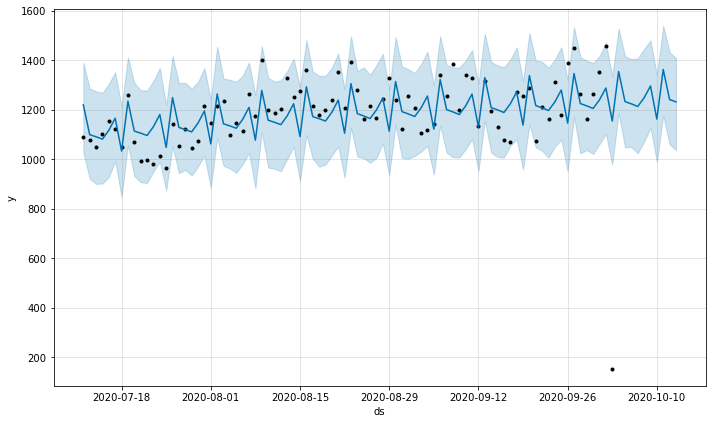

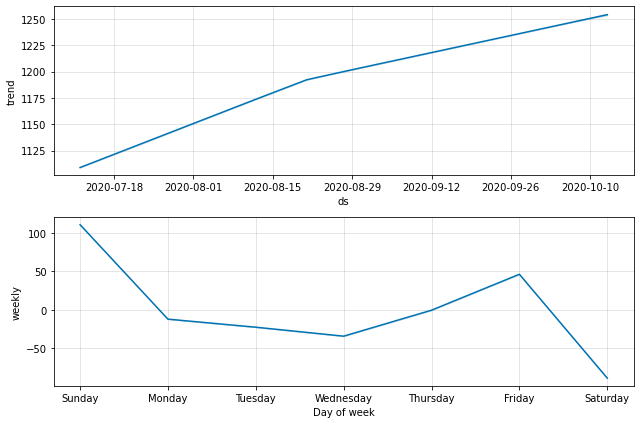

In [9]:
from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.05).fit(ts4)
future = m.make_future_dataframe(periods=10, freq='D')
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #breakdown of weekday seasonality and the time trend

Lets look at intraday seasonality and break down the posting frequency by hours:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


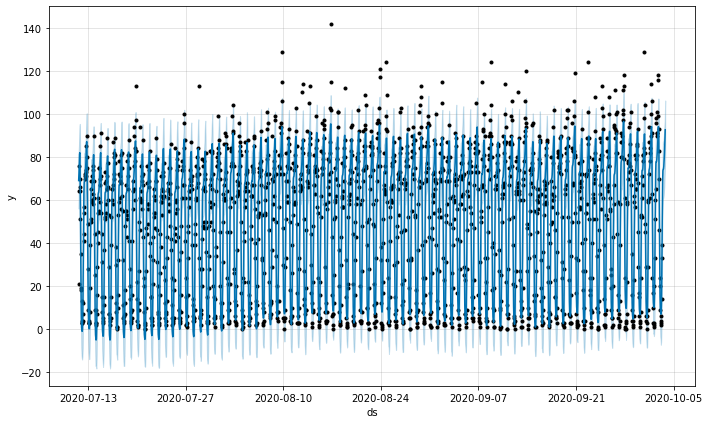

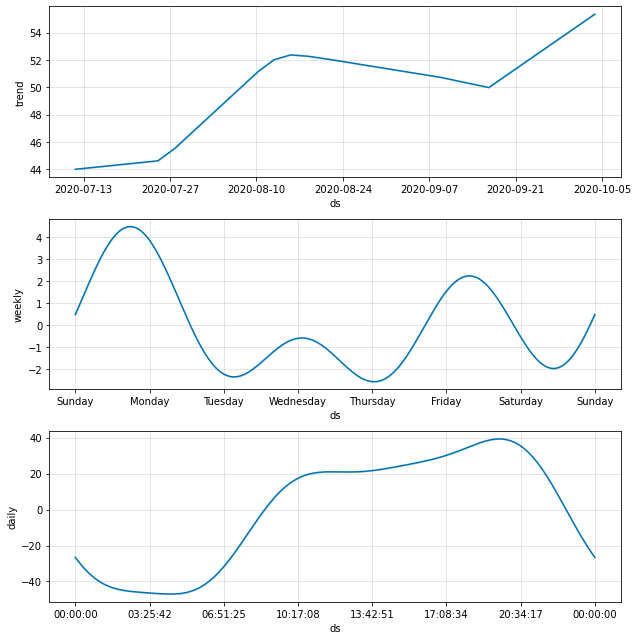

In [10]:
ts5 = ts3.resample('60T').sum()
ts5['ds'] = ts5.index
ts5.rename(columns={'count':'y'}, inplace = True)
#ts5.drop(min(ts4.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation

m = Prophet(changepoint_prior_scale=0.1).fit(ts5)
future = m.make_future_dataframe(periods=10, freq='H')
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #breakdown by time trend, weekday seasonality and intraday seasonality

##### Lets look at the tags

In [51]:
tags_all = pd.Series([tag for row in df.tags for tag in row])
len(tags_all) #153160

tags = tags_all.value_counts()
n_tags = len(tags) #142492 unique hashtags
toptags = tags.rename_axis('unique_values').reset_index(name='counts')[:10] 
# most used was helsinki with 3027
#print(toptags)
for tag in toptags["unique_values"]:
    df[tag] = df["tags"].apply(lambda x: 1 if tag in x else 0)

# this is something that we can just look at as a user in the end
print(n_tags)
print(tags['corona'])

142492
53


In [13]:
ts = df.set_index("timestamp")
ts = ts.resample('60T').sum()
ts['ds'] = ts.index

ts.rename(columns={toptags["unique_values"][0]:'y'}, inplace = True) #choose the tag to forecast 0 = top tag, 1 = 2nd etc

ts_tags = ts.rename(columns={'count':'y'})
ts_tags.drop(min(ts_tags.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


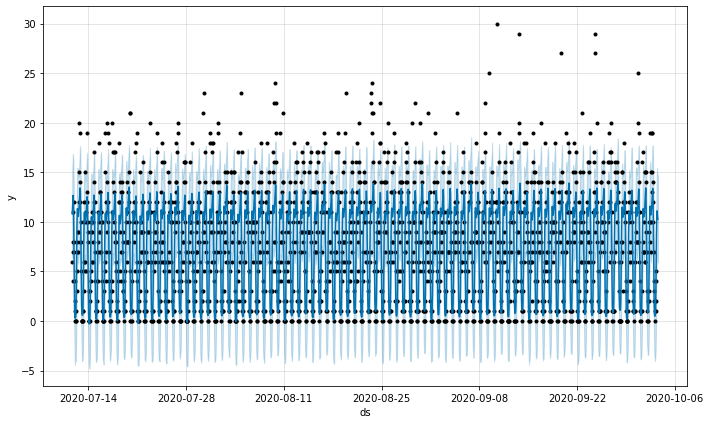

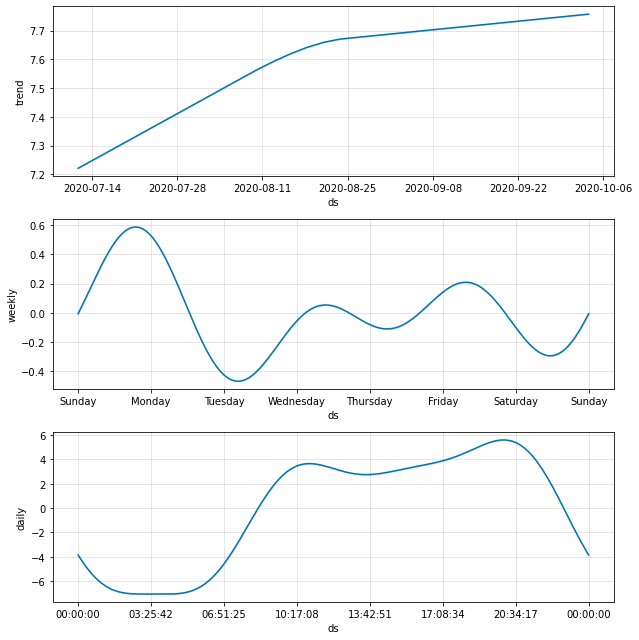

In [14]:
m = Prophet().fit(ts_tags)
future = m.make_future_dataframe(periods=5, freq='H') #choose the frequency to plot
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #time trend and weekday seasonality

In [42]:
print(df.location_name.value_counts())
print(df.address.value_counts())
print(df.zip_code.value_counts())
print(df.region_name.value_counts())
print(df.city_name.value_counts())



Helsinki                                                 99957
Finland                                                      3
Porn sex tube videos xxx pics pussy in porno xnxx com        2
Satamakatu 5                                                 1
Radio Rock                                                   1
Restaurant Demo                                              1
Pöllölaakso                                                  1
TAVASTIA-klubi                                               1
BasBas Kulma                                                 1
Helsinki Harbor                                              1
Linnanmäki                                                   1
IDEALfit Eira                                                1
Savoy-teatteri                                               1
Lauttasaari, Onnellisten saari                               1
Töölö                                                        1
Naistenklinikan Synnytysosasto                         